In [11]:
from wordcloud import WordCloud
import pandas as pd
from tfidf import extract_column, tf_idf, top_k_per_row, load_table, create_wordcloud
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sql_books = load_table("books.db", "books")
corpus = extract_column(sql_books, "description")
X, feature_names = tf_idf(corpus)
top_idx, top_data = top_k_per_row(X, 15)

DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG: findfont: score(FontEntry(fname='/home/dan/Venv/base_env/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG: findfont: score(FontEntry(fname='/home/dan/Venv/base_env/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG: findfont: score(FontEntry(fname='/home/dan/Venv/base_env/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=40

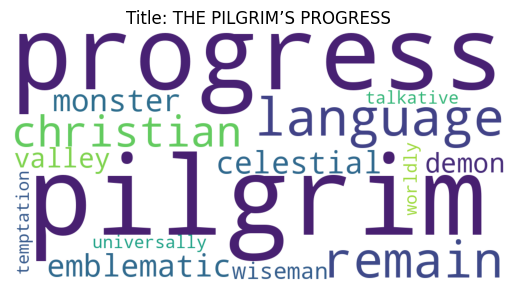

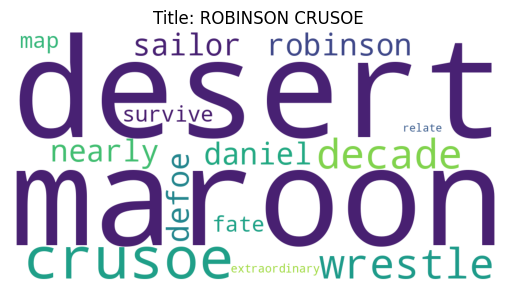

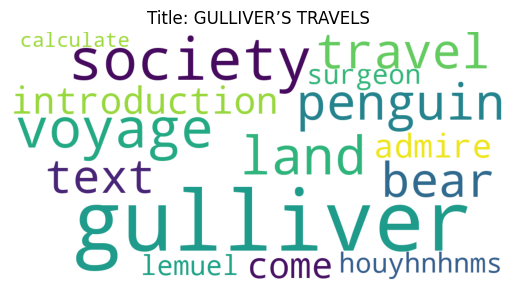

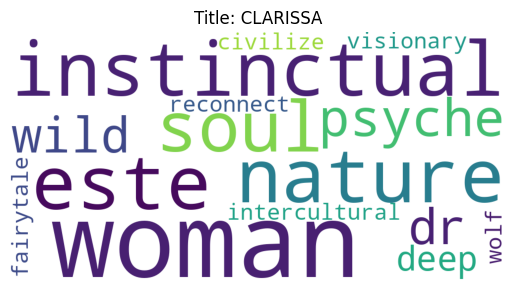

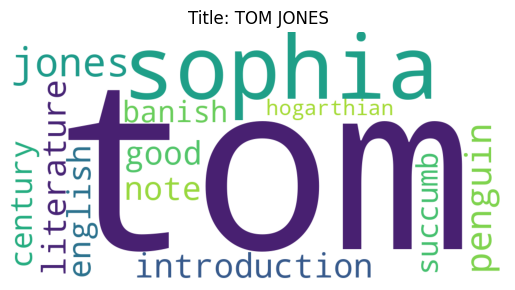

In [4]:

# List of all book titles
titles = extract_column(sql_books, 'title')
lengths = [len(idx) for idx in top_idx]

# Extract the first 5 books and their wordclouds
last = 5
for book_idx in range(last):
    create_wordcloud(feature_names[top_idx[book_idx]], top_data[book_idx], titles[book_idx])

In [47]:
from scipy import sparse

def keyword_search1(X, feature_names, feature, titles, top_n):
    """ Finds the maximum tf-idf value of a word in the corpus, and returns the name of the title with the maximum value of that word """
    word_idx = int(np.where(feature_names == feature)[0][0])

    X_csc = X if sparse.isspmatrix_csc(X) else X.tocsc()

    start, end = X_csc.indptr[word_idx], X_csc.indptr[word_idx + 1]

    data_slice = X_csc.data[start:end]
    rows_slice = X_csc.indices[start:end]

    k = min(top_n, data_slice.size)
    part = np.argpartition(-data_slice, k - 1)[:k]
    order = part[np.argsort(-data_slice[part])]
 
    return [(titles[rows_slice[i]], float(data_slice[i])) for i in order]

In [50]:
# Search function using keywords
print(keyword_search1(X, feature_names, 'woman', titles, 5))

[('CLARISSA', 0.43913827213540524), ('LITTLE WOMEN', 0.24860416176064518), ('THE SIGN OF FOUR', 0.18229294136295346), ('KIM', 0.14480368404314398), ('VANITY FAIR', 0.13418778589936545)]
